In [28]:
import pandas as pd

def load_data(file_path):
    """Load data from a CSV file into a pandas DataFrame."""
    return pd.read_csv(file_path).drop('Id', axis=1)


train_data = load_data('./data/train.csv')
test_data = load_data('./data/test.csv')
print(train_data.info())
print(train_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# ----------------------
# 1. Charger le dataset
# ----------------------
def load_data(path):
    return pd.read_csv(path)

train_data = load_data('./data/train.csv')
test_data  = load_data('./data/test.csv')
target = "SalePrice"

X = train_data.drop(columns=[target])
y = train_data[target]

# ----------------------
# 2. Identifier types
# ----------------------
numerical_cols   = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns

# ----------------------
# 3. Préprocessing
# ----------------------
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

# ----------------------
# 4. Split train/test
# ----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------
# 5. Hyperparameter grids
# ----------------------
param_grid_xgb = {
    'n_estimators': [200, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

param_grid_lgb = {
    'n_estimators': [200, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

param_grid_cat = {
    'iterations': [200, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

# ----------------------
# 6. Modèles
# ----------------------
xgb_model = xgb.XGBRegressor(random_state=42, verbosity=0)
lgb_model = lgb.LGBMRegressor(random_state=42)
cat_model = CatBoostRegressor(verbose=0, random_seed=42)

# ----------------------
# 7. GridSearchCV avec pipeline
# ----------------------
def tune_model(model, param_grid):
    pipeline = Pipeline([
        ('preproc', preprocessor),
        ('model', model)
    ])
    grid = GridSearchCV(
        pipeline, 
        param_grid={'model__' + k: v for k, v in param_grid.items()},
        scoring='neg_mean_absolute_error',
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    print(f"Best params for {model.__class__.__name__}: {grid.best_params_}")
    return grid.best_estimator_

best_xgb = tune_model(xgb_model, param_grid_xgb)
best_lgb = tune_model(lgb_model, param_grid_lgb)
best_cat = tune_model(cat_model, param_grid_cat)

# ----------------------
# 8. Stacking
# ----------------------
stack_model = StackingRegressor(
    estimators=[
        ('xgb', best_xgb),
        ('lgb', best_lgb),
        ('cat', best_cat)
    ],
    final_estimator=CatBoostRegressor(iterations=500, verbose=0, random_seed=42),
    n_jobs=-1
)
stack_model.fit(X_train, y_train)

# ----------------------
# 9. Evaluation
# ----------------------
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    mape = mean_absolute_percentage_error(y_test, preds) * 100
    print(f"MAE: {mae:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")
    return mae, r2, mape

print("\nXGBoost (tuned):")
mae_xgb, r2_xgb, mape_xgb = evaluate_model(best_xgb, X_test, y_test)

print("\nLightGBM (tuned):")
mae_lgb, r2_lgb, mape_lgb = evaluate_model(best_lgb, X_test, y_test)

print("\nCatBoost (tuned):")
mae_cat, r2_cat, mape_cat = evaluate_model(best_cat, X_test, y_test)

print("\nStacking Regressor:")
mae_stack, r2_stack, mape_stack = evaluate_model(stack_model, X_test, y_test)

# Comparaison
results_df = pd.DataFrame([
    ['XGBoost', mae_xgb, r2_xgb, mape_xgb],
    ['LightGBM', mae_lgb, r2_lgb, mape_lgb],
    ['CatBoost', mae_cat, r2_cat, mape_cat],
    ['Stacking', mae_stack, r2_stack, mape_stack]
], columns=['Model', 'MAE', 'R2', 'MAPE']).sort_values('MAE')

print("\nComparaison finale :")
print(results_df)



Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best params for XGBRegressor: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 500, 'model__subsample': 0.8}
Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Best params for LGBMRegressor: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 500, 'model__num_leaves': 31, 'model__subsample': 0.7}
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best params for CatBoostRegressor: {'model__depth': 6, 'model__iterations': 500, 'model__l2_leaf_reg': 1, 'model__learning_rate': 0.05}

XGBoost (tuned):
MAE: 15734.08, R²: 0.9167, MAPE: 9.37%

LightGBM (tuned):
MAE: 17158.40, R²: 0.8814, MAPE: 9.90%

CatBoost (tuned):
MAE: 15770.53, R²: 0.8977, MAPE: 9.19%

Stacking Regressor:
MAE: 16899.03, R²: 0.8695, MAPE: 9.69%

Comparaison finale :
      Model           MAE        R2      MAPE
0   XGBoos

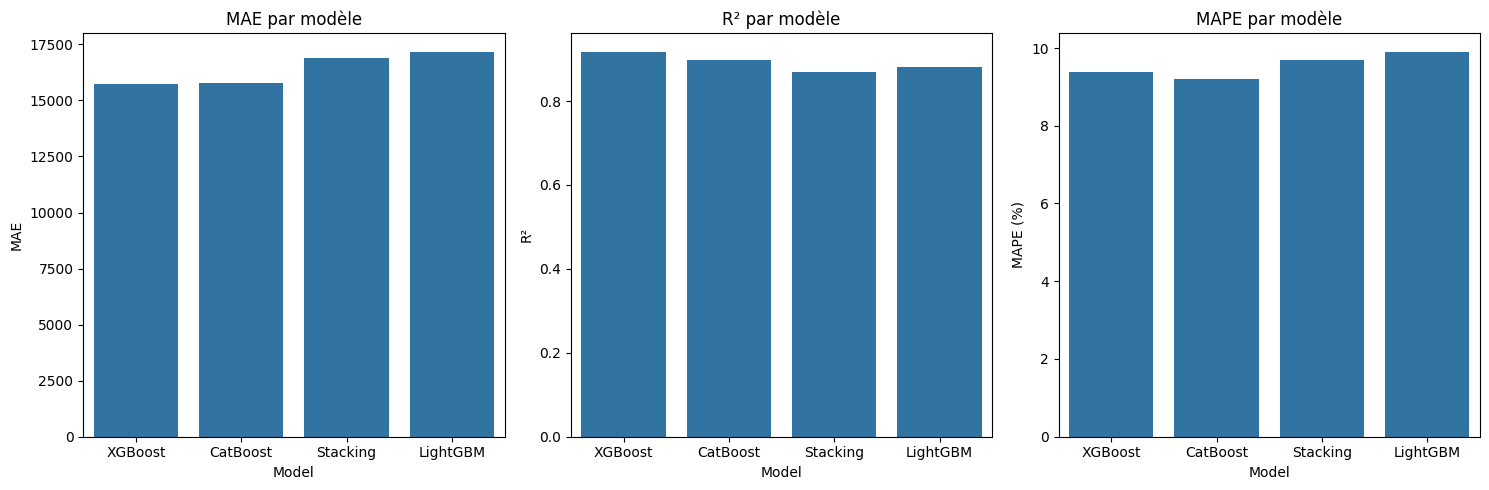

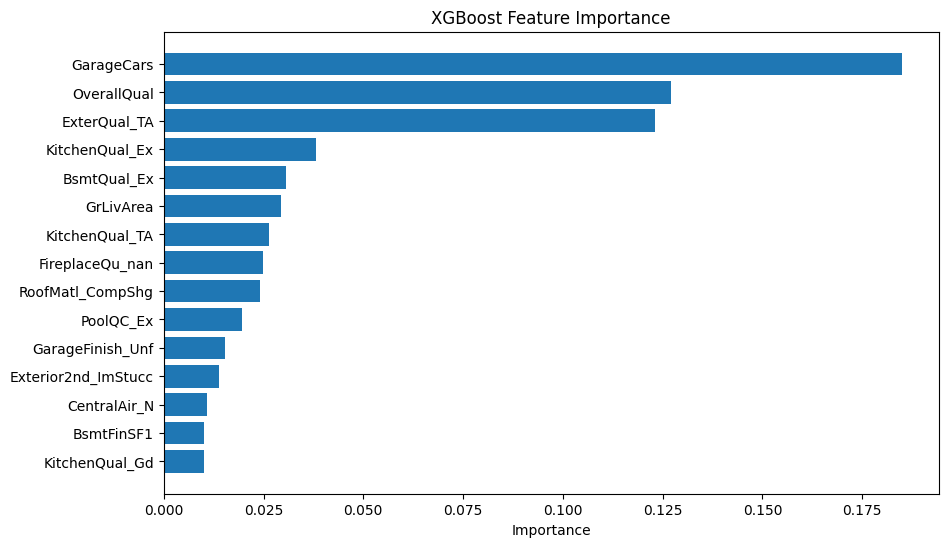

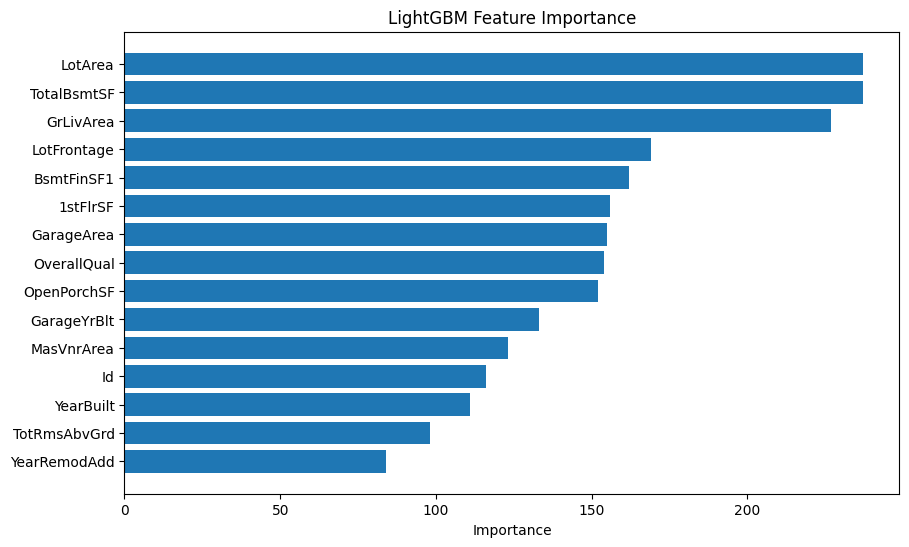

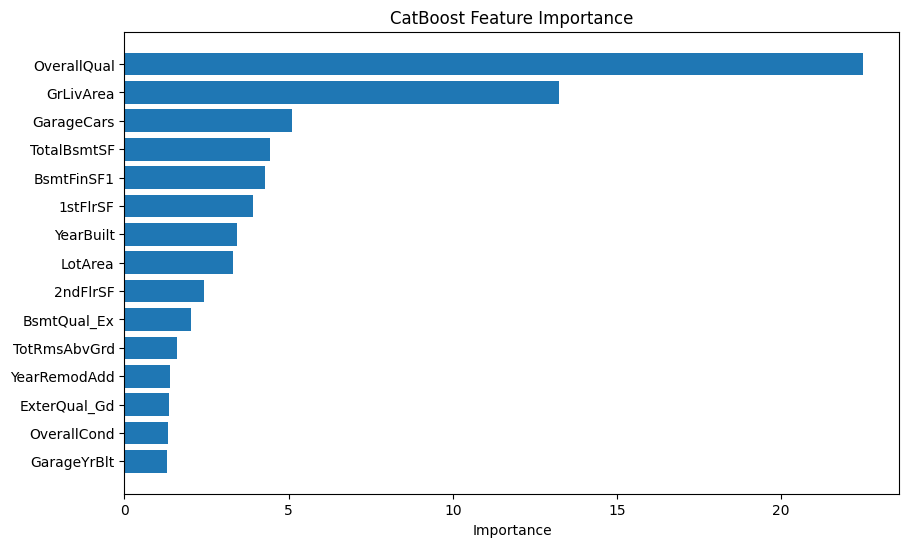

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----------------------
# 1. Comparaison des modèles
# ----------------------
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.barplot(x="Model", y="MAE", data=results_df)
plt.title("MAE par modèle")
plt.ylabel("MAE")

plt.subplot(1,3,2)
sns.barplot(x="Model", y="R2", data=results_df)
plt.title("R² par modèle")
plt.ylabel("R²")

plt.subplot(1,3,3)
sns.barplot(x="Model", y="MAPE", data=results_df)
plt.title("MAPE par modèle")
plt.ylabel("MAPE (%)")

plt.tight_layout()
plt.show()


# ----------------------
# 2. Récupérer les noms des features après preprocessing
# ----------------------
def get_feature_names_from_pipeline(pipeline):
    preprocessor = pipeline.named_steps['preproc']
    feature_names = []

    # Colonnes numériques
    feature_names.extend(preprocessor.named_transformers_['num'].feature_names_in_)

    # Colonnes catégorielles
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(preprocessor.transformers_[1][2])
    feature_names.extend(cat_names)

    return feature_names

# Pour chaque modèle
feature_names_xgb = get_feature_names_from_pipeline(best_xgb)
feature_names_lgb = get_feature_names_from_pipeline(best_lgb)
feature_names_cat = get_feature_names_from_pipeline(best_cat)

# ----------------------
# 3. Plot feature importance
# ----------------------
def plot_feature_importance(model, feature_names, top_n=20, title="Feature Importance"):
    if hasattr(model.named_steps['model'], "feature_importances_"):
        importances = model.named_steps['model'].feature_importances_
    elif hasattr(model.named_steps['model'], "get_feature_importance"):  # CatBoost
        importances = model.named_steps['model'].get_feature_importance()
    else:
        raise ValueError("Model does not have feature importance attribute.")
    
    indices = np.argsort(importances)[-top_n:]
    plt.figure(figsize=(10,6))
    plt.barh(range(top_n), importances[indices], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.title(title)
    plt.xlabel("Importance")
    plt.show()

# Affichage
plot_feature_importance(best_xgb, feature_names_xgb, top_n=15, title="XGBoost Feature Importance")
plot_feature_importance(best_lgb, feature_names_lgb, top_n=15, title="LightGBM Feature Importance")
plot_feature_importance(best_cat, feature_names_cat, top_n=15, title="CatBoost Feature Importance")

